# SPaRTA

In [1]:
import sparta
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams.update({"text.usetex": True,
                     "font.family": "Times new roman"})
colors =  ['#377eb8', '#ff7f00', '#4daf4a',
           '#f781bf', '#a65628', '#984ea3',
           '#999999', '#e41a1c', '#dede00']

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

## Compare trajectories

In [2]:
all_photons_data_ms = sparta.run_SPaRTA(
    random_seed=10,
    N = 5, Delta_L=0.08,
)

all_photons_data_sl = sparta.run_SPaRTA(
    STRAIGHT_LINE = True,
    INCLUDE_RECOIL = False,
    N = 1,
)

100%|██████████| 1/1 [00:00<00:00, 11.76photons/s]


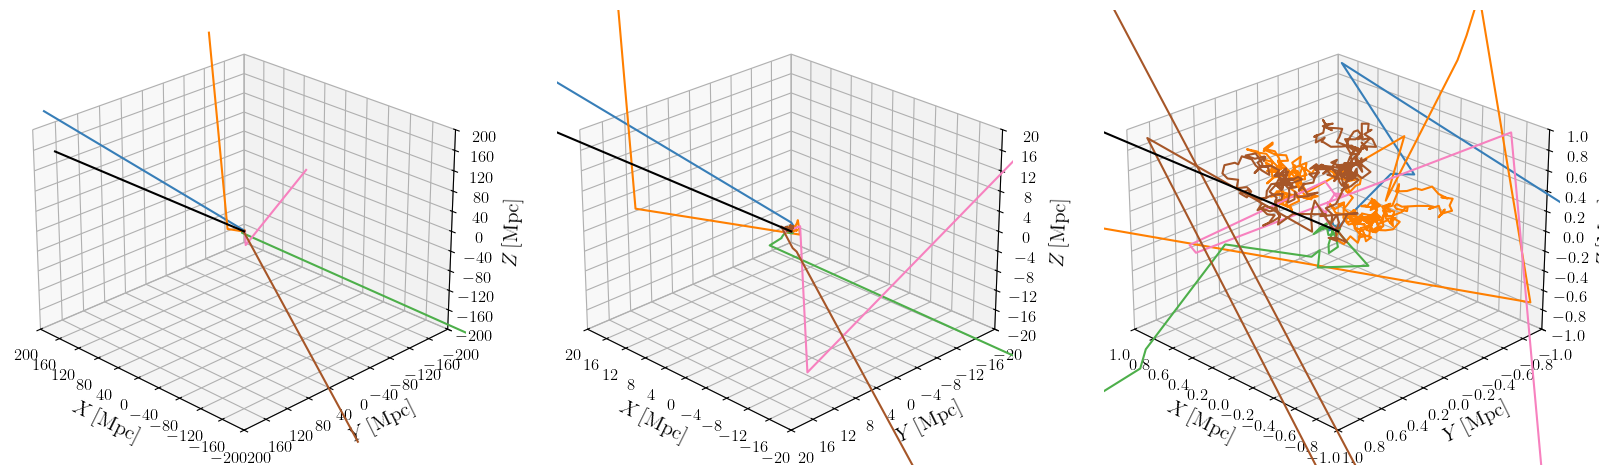

In [3]:
scales = [200,20,1]
fig = plt.figure(figsize=(20,40))
for scale_ind, scale in enumerate(scales):
    ax =  fig.add_subplot(1,3,scale_ind+1,projection='3d')
    for n in range(5):
        all_photons_data_ms.plot_photon_trajectory(n,color=colors[n],ax=ax,scale=scale)
    all_photons_data_sl.plot_photon_trajectory(0,color='k',ax=ax,scale=scale)
    ax.view_init(elev=25., azim=135.)

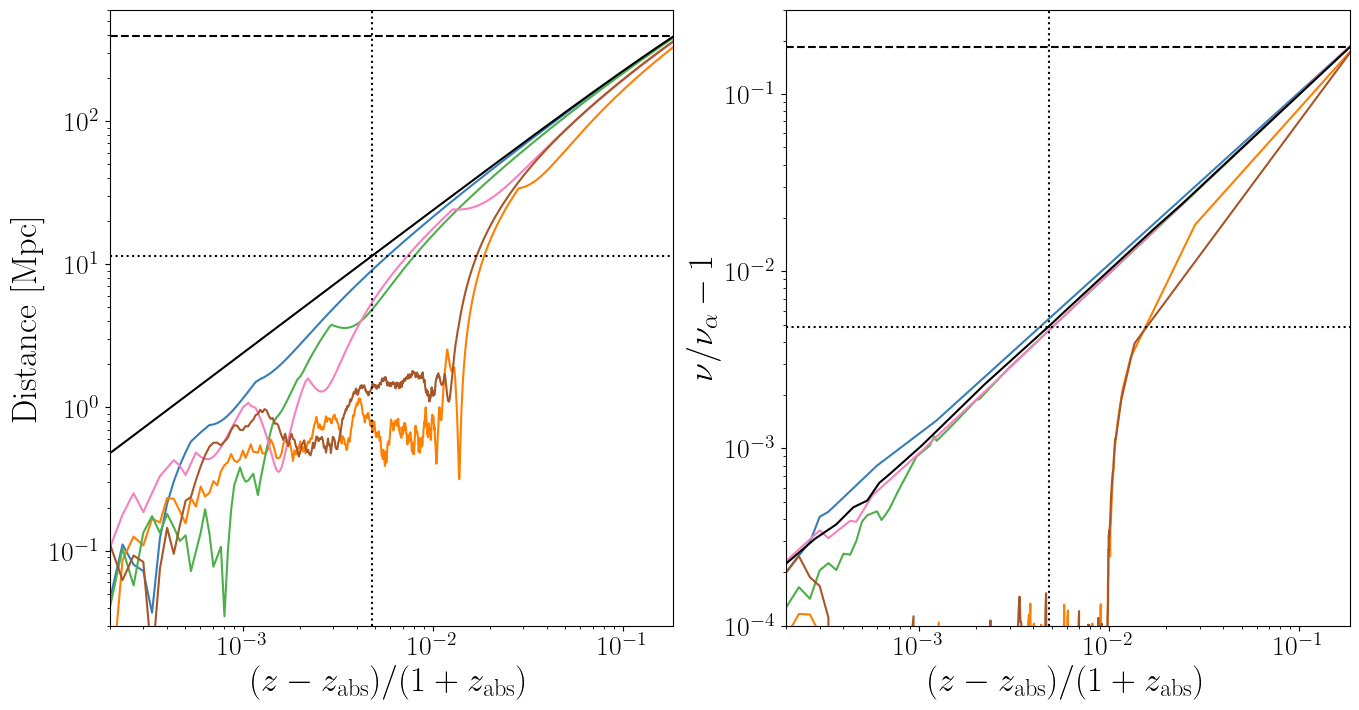

In [4]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
for n in range(5):
    all_photons_data_ms.plot_distance(n,color=colors[n],ax=ax[0])
    all_photons_data_ms.plot_apparent_frequency(n,color=colors[n],ax=ax[1])
all_photons_data_sl.plot_distance(0,color='k',ax=ax[0])
all_photons_data_sl.plot_apparent_frequency(0,color='k',ax=ax[1])
ax[0].set_ylim([0.03,600])
ax[1].set_ylim([1e-4,0.3])
# Add a Lymann beta horizontal dashed line (nu_stop in this example is Lyman beta)
max_redshift = (1.+all_photons_data_sl.z_abs)*all_photons_data_sl.sim_params.nu_stop-1.
max_distance = all_photons_data_sl.cosmo_params.R_SL(all_photons_data_sl.z_abs,max_redshift)
ax[0].axhline(y=max_distance,ls='--',color='k')
ax[1].axhline(y=all_photons_data_sl.sim_params.nu_stop-1.,ls='--',color='k')
# Add a diffusion horizontal dotted line
ax[0].axhline(y=all_photons_data_sl.cosmo_params.r_star(all_photons_data_sl.z_abs),ls=':',color='k')
ax[0].axvline(x=all_photons_data_sl.cosmo_params.Delta_nu_star(all_photons_data_sl.z_abs),ls=':',color='k')
ax[1].axhline(y=all_photons_data_sl.cosmo_params.Delta_nu_star(all_photons_data_sl.z_abs),ls=':',color='k')
ax[1].axvline(x=all_photons_data_sl.cosmo_params.Delta_nu_star(all_photons_data_sl.z_abs),ls=':',color='k');

## Check distributions

100%|██████████| 1000/1000 [01:14<00:00, 13.47photons/s]


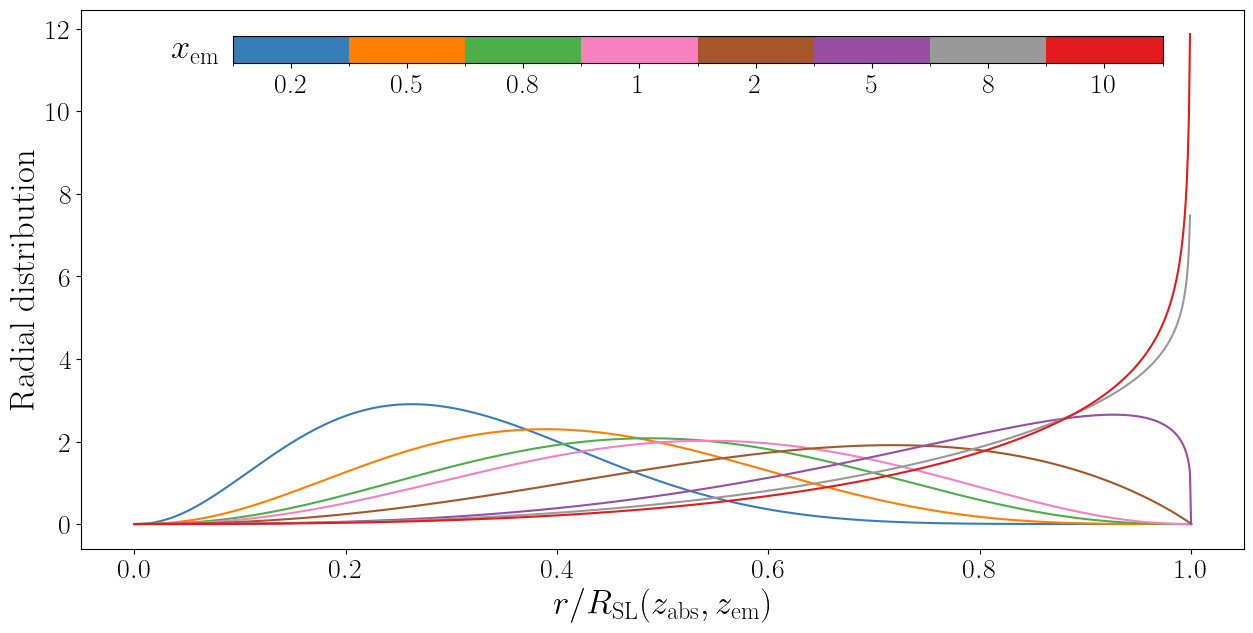

In [5]:
# Create a discrete colorbar
def add_discrete_color_bar(n_values,colors,x_labels,label,ax,inset_bounds=[0.13, 0.9, 0.8, 0.05],label_below=False):
    cmap = mpl.colors.ListedColormap(colors)
    norm = mpl.colors.BoundaryNorm(boundaries=np.arange(n_values+1)-0.5, ncolors=n_values)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    cax = ax.inset_axes(inset_bounds)
    cbar = plt.colorbar(sm, orientation='horizontal', ticks=range(n_values), cax=cax)
    cbar.ax.set_xticklabels(x_labels,fontsize=20)
    if label_below:
        cbar.ax.set_xlabel(label,fontsize=25,rotation=0,labelpad=10, ha='right', va='center')
    else:
        cbar.ax.set_ylabel(label,fontsize=25,rotation=0,labelpad=10, ha='right', va='center')
    return cbar

all_photons_data = sparta.run_SPaRTA()
sim_data = sparta.SIM_DATA(all_photons_data)
x_em_list = [0.2, 0.5, 0.8, 1., 2., 5., 8., 10.]
fig, ax = plt.subplots(1, 1, figsize=(15,7))
for ind, x_em in enumerate(x_em_list):
    fig, ax = sim_data.plot_fit(x_em=x_em, ax=ax, color = colors[ind])
x_labels =[f"{x_em:.1f}" if x_em < 1. else f"{x_em:.0f}" for x_em in x_em_list]
cbar = add_discrete_color_bar(n_values=len(x_em_list),colors=colors,x_labels=x_labels,label="$x_\\mathrm{em}$",ax=ax);

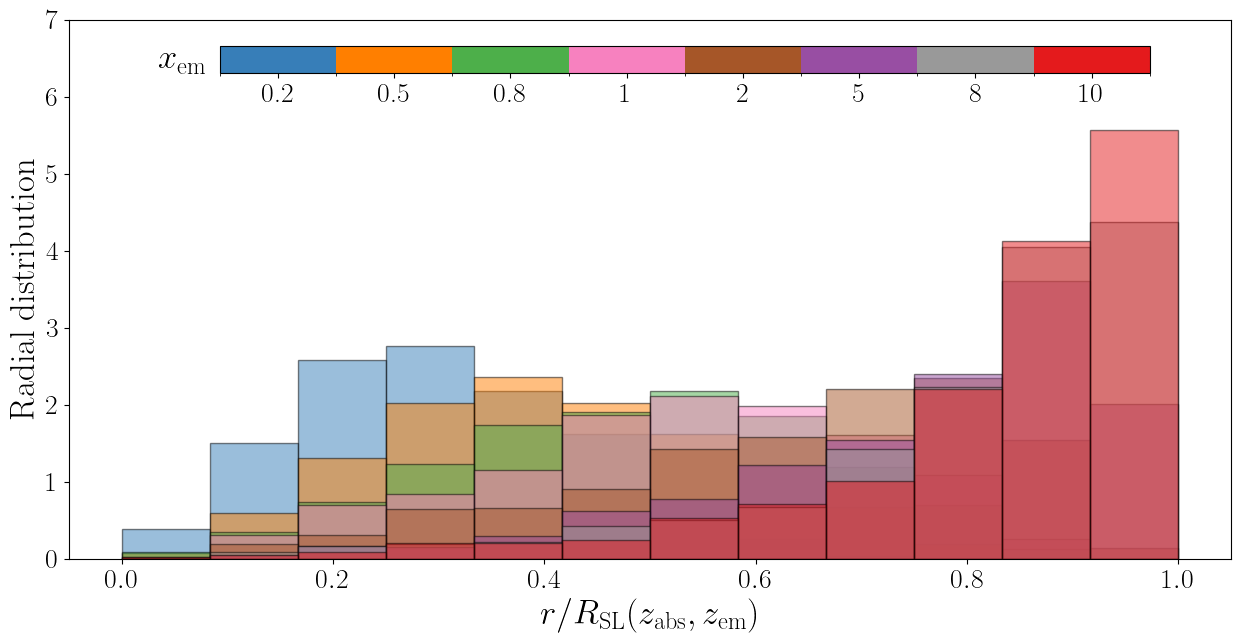

In [6]:
histogram_data = sim_data.get_histogram(N_bins=12)
x_em_list = [0.2, 0.5, 0.8, 1., 2., 5., 8., 10.]
fig, ax = plt.subplots(1, 1, figsize=(15,7))
for ind, x_em in enumerate(x_em_list):
    fig, ax = histogram_data.plot_histogram(x_em=x_em, ax=ax, color = colors[ind],alpha=0.5)
ax.set_ylim([0,7])
x_labels =[f"{x_em:.1f}" if x_em < 1. else f"{x_em:.0f}" for x_em in x_em_list]
cbar = add_discrete_color_bar(n_values=len(x_em_list),colors=colors,x_labels=x_labels,label="$x_\\mathrm{em}$",ax=ax);

## Plot cross-section

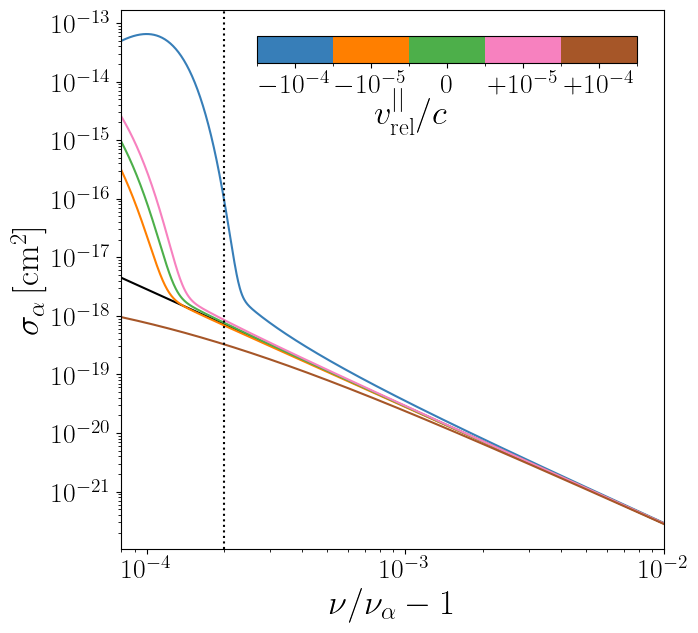

In [7]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
fig, ax = sparta.plot_cross_section(T=0, nu_min=8e-5, nu_max=1e-2, ax=ax,color='k')
fig, ax = sparta.plot_cross_section(T=1e4, nu_min=8e-5, nu_max=1e-2, velocity=-1e-4,ax=ax)
fig, ax = sparta.plot_cross_section(T=1e4, nu_min=8e-5, nu_max=1e-2, velocity=1e-5,ax=ax)
fig, ax = sparta.plot_cross_section(T=1e4, nu_min=8e-5, nu_max=1e-2, ax=ax)
fig, ax = sparta.plot_cross_section(T=1e4, nu_min=8e-5, nu_max=1e-2, velocity=-1e-5,ax=ax)
fig, ax = sparta.plot_cross_section(T=1e4, nu_min=8e-5, nu_max=1e-2, velocity=1e-4,ax=ax)
ax.axvline(2e-4,color='k',ls=':')
ax.axvline(1e-1,color='k',ls='--')
x_labels = ['$-10^{-4}$','$-10^{-5}$','$0$','$+10^{-5}$','$+10^{-4}$']
cbar = add_discrete_color_bar(n_values=5,colors=colors,x_labels=x_labels,label="$v_\\mathrm{rel}^{||}/c$",ax=ax,
                              inset_bounds=[0.25, 0.9, 0.7, 0.05],label_below=True)

### Velocity effects

In [8]:
all_photons_data_with_v = sparta.run_SPaRTA(INCLUDE_VELOCITIES = True)
all_photons_data_without_v = sparta.run_SPaRTA(INCLUDE_VELOCITIES = False)

100%|██████████| 1000/1000 [00:19<00:00, 50.70photons/s]


In [9]:
sim_data_with_v = sparta.SIM_DATA(all_photons_data_with_v)
sim_data_without_v = sparta.SIM_DATA(all_photons_data_without_v)

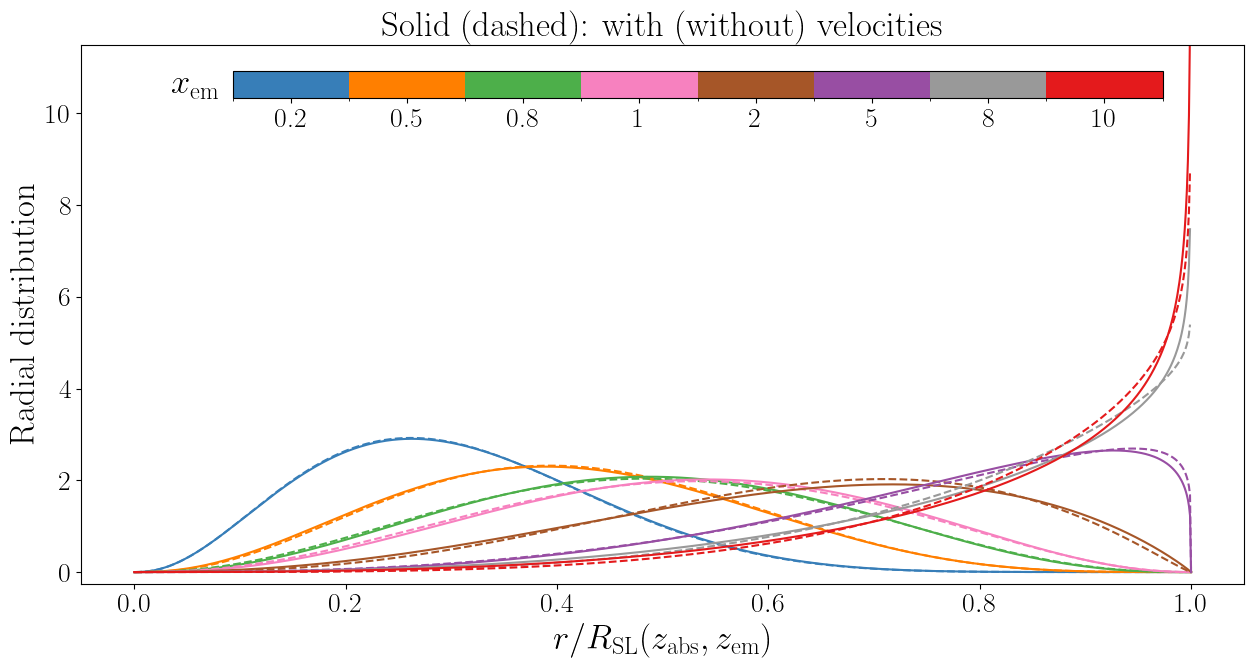

In [10]:
x_em_list = [0.2, 0.5, 0.8, 1., 2., 5., 8., 10.]
fig, ax = plt.subplots(1, 1, figsize=(15,7))
for ind, x_em in enumerate(x_em_list):
    fig, ax = sim_data_with_v.plot_fit(x_em=x_em, ax=ax, color = colors[ind])
    fig, ax = sim_data_without_v.plot_fit(x_em=x_em, ax=ax, color = colors[ind], ls = '--')
ax.set_title("Solid (dashed): with (without) velocities",fontsize=25)
ax.set_xlim([-0.05,1.05])
ax.set_ylim([-0.25,11.5])
x_labels =[f"{x_em:.1f}" if x_em < 1. else f"{x_em:.0f}" for x_em in x_em_list]
cbar = add_discrete_color_bar(n_values=len(x_em_list),colors=colors,x_labels=x_labels,label="$x_\\mathrm{em}$",ax=ax);

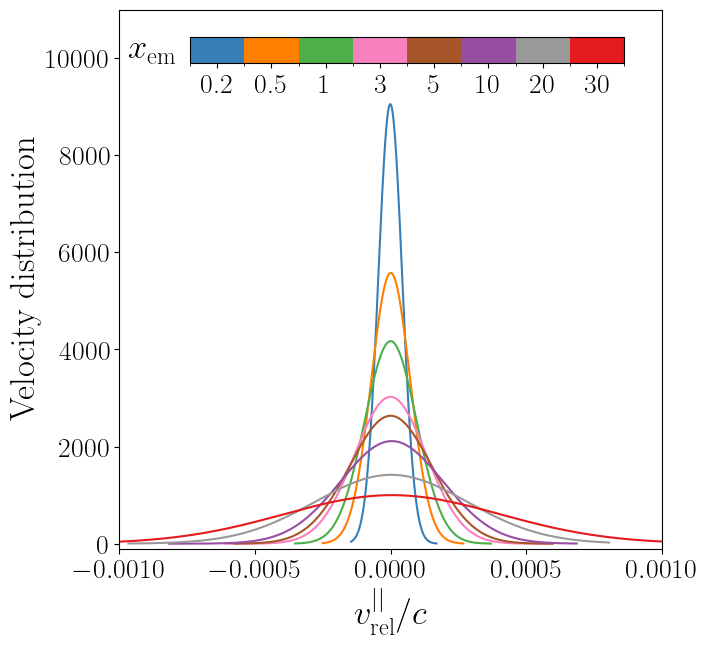

In [11]:
sim_data_velocity = sparta.SIM_DATA(all_photons_data_with_v,quantity="velocity")

x_em_list = [0.2,0.5,1.,3.,5.,10.,20.,30.]
fig, ax = plt.subplots(1, 1, figsize=(7,7))
for x_em in x_em_list:
    fig, ax = sim_data_velocity.plot_fit(x_em=x_em, ax=ax)
ax.set_xlim([-1e-3,1e-3])
ax.set_ylim([-100,11000])
x_labels =[f"{x_em:.1f}" if x_em < 1. else f"{x_em:.0f}" for x_em in x_em_list]
cbar = add_discrete_color_bar(n_values=len(x_em_list),colors=colors,x_labels=x_labels,label="$x_\\mathrm{em}$",ax=ax);

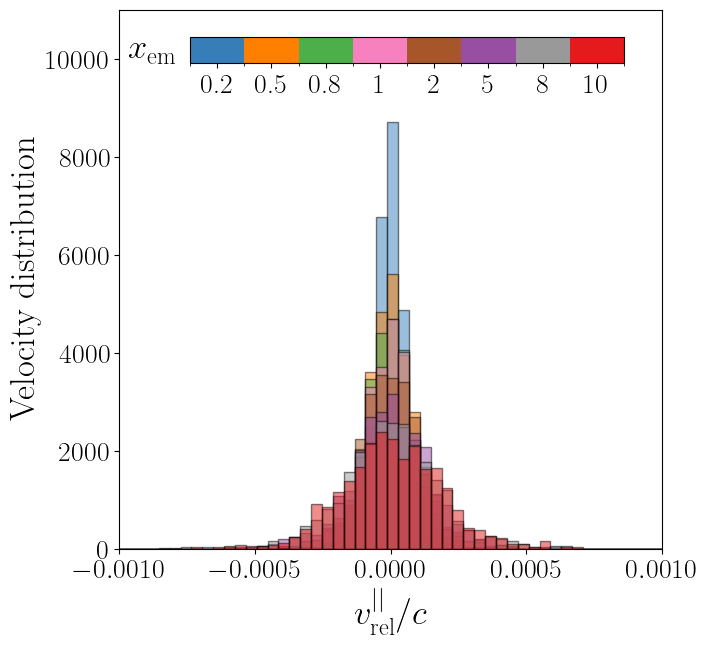

In [12]:
histogram_data_velocity = sim_data_velocity.get_histogram(N_bins=80)
x_em_list = [0.2, 0.5, 0.8, 1., 2., 5., 8., 10.]
fig, ax = plt.subplots(1, 1, figsize=(7,7))
for ind, x_em in enumerate(x_em_list):
    fig, ax = histogram_data_velocity.plot_histogram(x_em=x_em, ax=ax, color = colors[ind],alpha=0.5)
ax.set_xlim([-1e-3,1e-3])
ax.set_ylim([0,11000])
x_labels =[f"{x_em:.1f}" if x_em < 1. else f"{x_em:.0f}" for x_em in x_em_list]
cbar = add_discrete_color_bar(n_values=len(x_em_list),colors=colors,x_labels=x_labels,label="$x_\\mathrm{em}$",ax=ax);

# Check correlation function

This is an attempt to replicate Fig. 6 in https://arxiv.org/pdf/2302.08506.

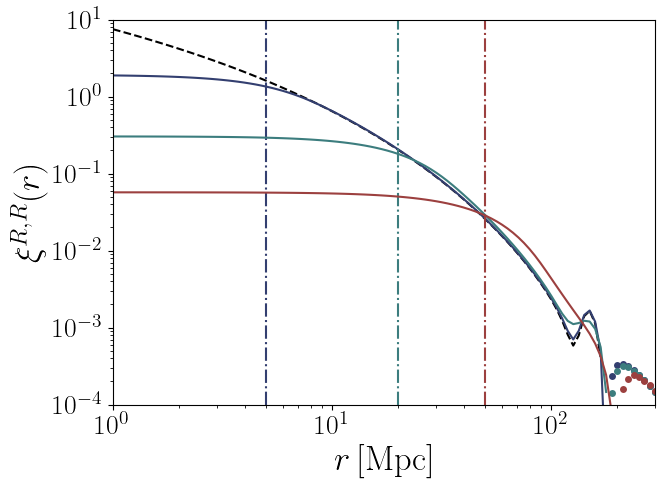

In [5]:
CLASS_OUTPUT = sparta.COSMO_PARAMS().run_CLASS()
r_array = np.logspace(0,np.log10(300),100)
fix, ax = plt.subplots(1,1,figsize=(7,5))
r_smooth_list = [0,5,20,50]
colors_for_this_fig = ['k','#333F70','#3C7D7E','#9C403F']
for ind, r_smooth in enumerate(r_smooth_list):
    xi_arr = np.array(
        [
            sparta.compute_correlation_function(
                CLASS_OUTPUT = CLASS_OUTPUT,
                r = r,
                r_smooth = r_smooth,
            ) 
        for r in r_array]
    )
    p_inds = xi_arr > 0
    n_inds = xi_arr < 0
    if r_smooth == 0:
        ls = '--'
    else:
        ls = '-'
    color = colors_for_this_fig[ind]
    ax.loglog(r_array[p_inds],xi_arr[p_inds],color=color,ls=ls)
    if r_smooth > 0:
        ax.loglog(r_array[n_inds],abs(xi_arr[n_inds]),ls='',marker='o',markerfacecolor=color,markeredgecolor='none',markersize=5)
    ax.axvline(r_smooth,ls='-.',color=color)
ax.set_xlim([1,300])
ax.set_ylim([1e-4,10])
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlabel('$r\\,[\\mathrm{Mpc}]$',fontsize=25)
ax.set_ylabel('$\\xi^{R,R}(r)$',fontsize=25);

In [4]:
CLASS_OUTPUT = sparta.COSMO_PARAMS().run_CLASS()
sigma8 = sparta.compute_RMS(
    CLASS_OUTPUT = CLASS_OUTPUT,
    r_smooth = 8/CLASS_OUTPUT.h(),
    z=0
)
print(f"sigma8 = {sigma8}")

sigma8 = 0.8124835747457804


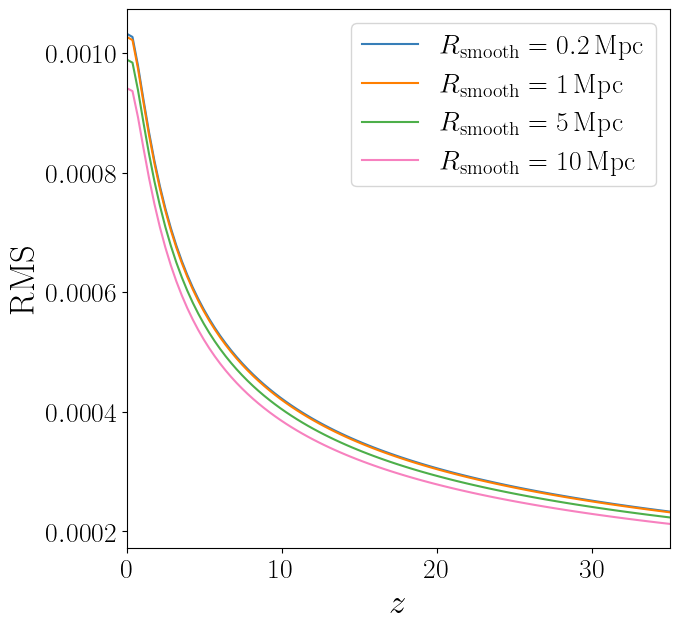

In [3]:
CLASS_OUTPUT = sparta.COSMO_PARAMS().run_CLASS()
r_smooth_list = [0.2,1,5,10]
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
for r_smooth in r_smooth_list:
    fig, ax = sparta.plot_RMS(
        CLASS_OUTPUT = CLASS_OUTPUT,
        r_smooth = r_smooth,
        ax = ax,
        kind = "velocity",
        label = "$R_\\mathrm{smooth}=" + f"{r_smooth}" + "\\,\\mathrm{Mpc}$"
    )

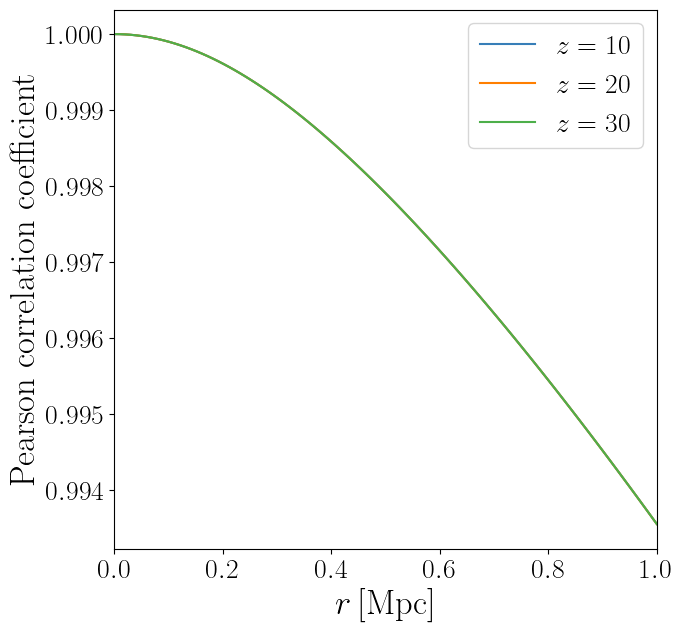

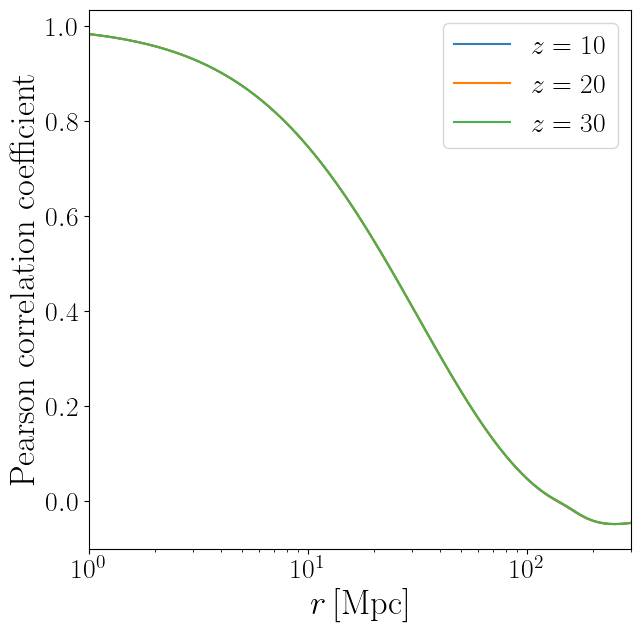

In [2]:
CLASS_OUTPUT = sparta.COSMO_PARAMS().run_CLASS()
z_list = [10,20,30]
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
for z in z_list:
    fig, ax = sparta.plot_Pearson_coefficient(
        CLASS_OUTPUT = CLASS_OUTPUT,
        z = z,
        r_smooth = 0.2,
        r_min = 0.,
        r_max = 1.,
        evolve_z2 = True,
        ax = ax,
        kinds = ("v_perp","v_perp"),
        label = "$z=" + f"{z}" + "$"
    )

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
for z in z_list:
    fig, ax = sparta.plot_Pearson_coefficient(
        CLASS_OUTPUT = CLASS_OUTPUT,
        z = z,
        r_smooth = 0.2,
        r_min = 1.,
        r_max = 300.,
        evolve_z2 = True,
        log_x = True,
        ax = ax,
        kinds = ("v_parallel","v_parallel"),
        label = "$z=" + f"{z}" + "$"
    )

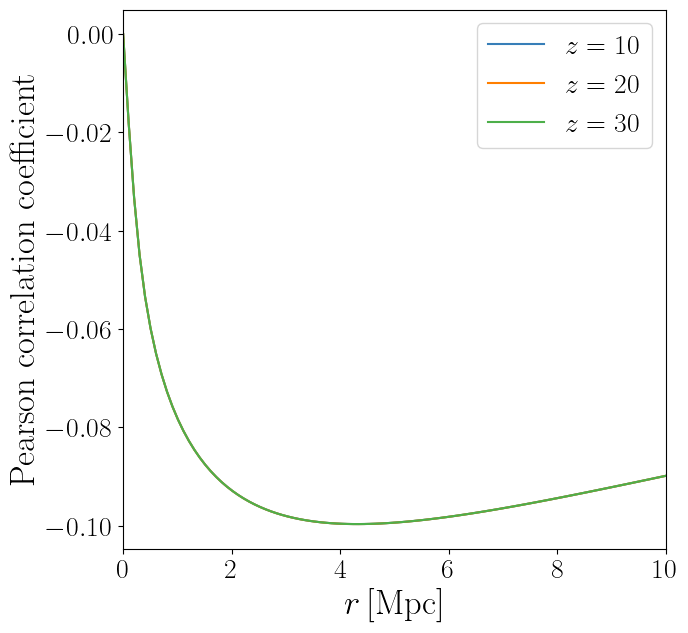

In [6]:
CLASS_OUTPUT = sparta.COSMO_PARAMS().run_CLASS()
z_list = [10,20,30]
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
for z in z_list:
    fig, ax = sparta.plot_Pearson_coefficient(
        CLASS_OUTPUT = CLASS_OUTPUT,
        z = z,
        r_smooth = 0.2,#sim_params["Delta_L"],
        r_min = 0.,
        r_max = 10.,
        ax = ax,
        kinds = ("density_b","v_parallel"),
        label = "$z=" + f"{z}" + "$"
    )

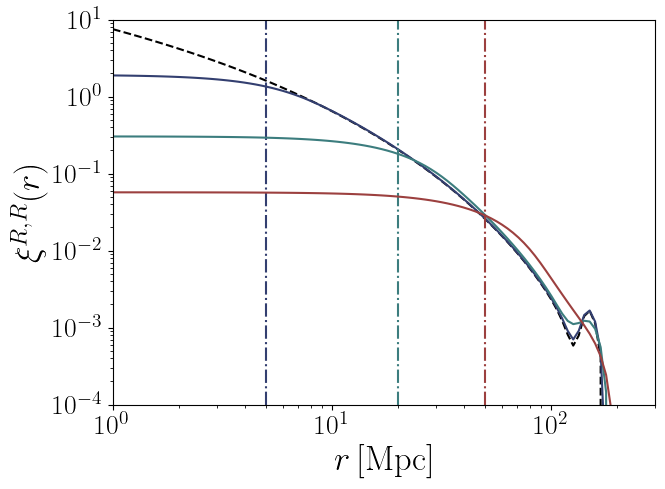

In [7]:
CLASS_OUTPUT = sparta.COSMO_PARAMS().run_CLASS()
r_smooth_list = [0,5,20,50]
colors_for_this_fig = ['k','#333F70','#3C7D7E','#9C403F']
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for ind, r_smooth in enumerate(r_smooth_list):
    if r_smooth == 0:
        ls = '--'
    else:
        ls = '-'
    fig, ax = sparta.plot_correlation_function(
        CLASS_OUTPUT = CLASS_OUTPUT,
        z = 0.,
        r_smooth = r_smooth,
        r_min = 1.,
        r_max = 300.,
        log_x = True,
        ax = ax,
        color=colors_for_this_fig[ind],
        ls = ls
    )
    ax.axvline(r_smooth,ls='-.',color=colors_for_this_fig[ind])
ax.set_xlim([1,300])
ax.set_ylim([1e-4,10])
ax.set_ylabel('$\\xi^{R,R}(r)$',fontsize=25)
ax.set_xscale('log')
ax.set_yscale('log');

(0.9996, 0.9995)

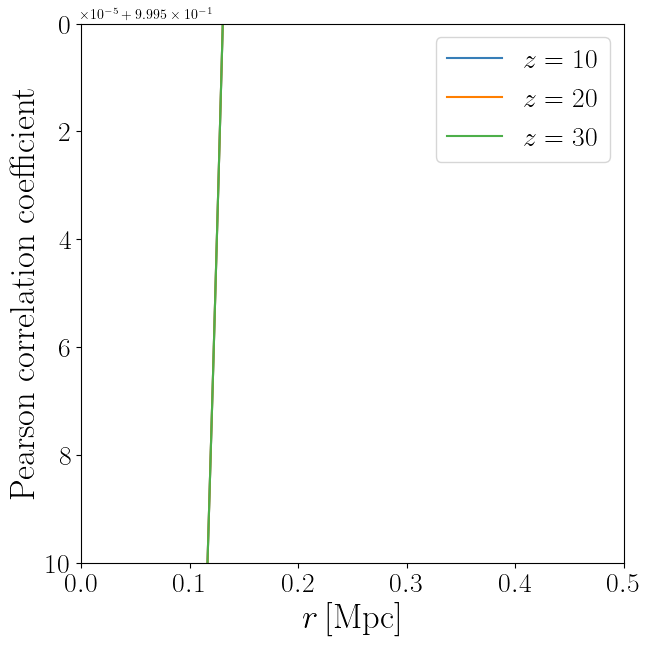

In [8]:
CLASS_OUTPUT = sparta.COSMO_PARAMS().run_CLASS()
z_list = [10,20,30]
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
for z in z_list:
    fig, ax = sparta.plot_Pearson_coefficient(
        CLASS_OUTPUT = CLASS_OUTPUT,
        z = z,
        r_smooth = 0.2,
        r_min = 0.,
        r_max = 0.5,
        evolve_z2 = True,
        ax = ax,
        kinds = ("v_parallel","v_parallel"),
        label = "$z=" + f"{z}" + "$"
    )
ax.set_ylim([1-4e-4,1-5e-4])